In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from pickle import load

In [2]:
# Defining the LSTM model with two hidden layers
class LSTMmodel(nn.Module):
    
    def __init__(self,input_size,hidden_size_1,hidden_size_2,out_size):
        
        super().__init__()
        
        self.hidden_size_1 = hidden_size_1
        
        self.hidden_size_2 = hidden_size_2
        
        self.input_size = input_size
        
        self.lstm_1 = nn.LSTM(input_size,hidden_size_1)
        
        self.lstm_2 = nn.LSTM(hidden_size_1,hidden_size_2)
        
        self.linear = nn.Linear(hidden_size_2,out_size)
        
        self.hidden_1 = (torch.zeros(1,1,hidden_size_1), torch.zeros(1,1,hidden_size_1))
        
        self.hidden_2 = (torch.zeros(1,1,hidden_size_2), torch.zeros(1,1,hidden_size_2))
        
    def forward(self,seq):
        
        lstm_out_1 , self.hidden_1 = self.lstm_1(seq.view(-1,1,self.input_size),self.hidden_1)
        
        lstm_out_2 , self.hidden_2 = self.lstm_2(lstm_out_1,self.hidden_2)
        
        pred = self.linear(lstm_out_2.view(len(seq),-1))
        
        return pred

In [3]:
model = LSTMmodel(input_size=4,hidden_size_1=50,hidden_size_2=50,out_size=2)

# Loading the saved torch model and setting it in evaluation mode
model.load_state_dict(torch.load('Models/LSTM_CSTR_model'))
model.eval()

# Loading the scalers to transform the new testing data set
scaler1 = load(open('Models/scaler1.pkl', 'rb'))
scaler2 = load(open('Models/scaler2.pkl', 'rb'))

In [4]:
df = pd.read_csv('Data/LSTM_test_data.csv')

In [5]:
test_set = df.values.astype(float)

In [6]:
# Scaling the new test data
test_norm_states = scaler1.transform(test_set[:,:2].reshape(-1,2))
test_norm_inputs = scaler2.transform(test_set[:,2:].reshape(-1,2))

test_norm = np.hstack((test_norm_states, test_norm_inputs))

In [7]:
test_set_norm = torch.FloatTensor(test_norm).view(-1,df.shape[1])

In [8]:
future = len(test_set) - 1

preds = [test_set_norm[0,:2].reshape(-1,2)]

for i in range(future):
    seq = test_set_norm[i].reshape(-1,4)
    with torch.no_grad():
        model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                        torch.zeros(1,1,model.hidden_size_1))
        model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                        torch.zeros(1,1,model.hidden_size_2))
        preds.append(model(seq))

In [9]:
predictions = scaler1.inverse_transform(np.array([pred.numpy() for pred in preds]).reshape(-1,2))

true_values = test_set[:,:2]

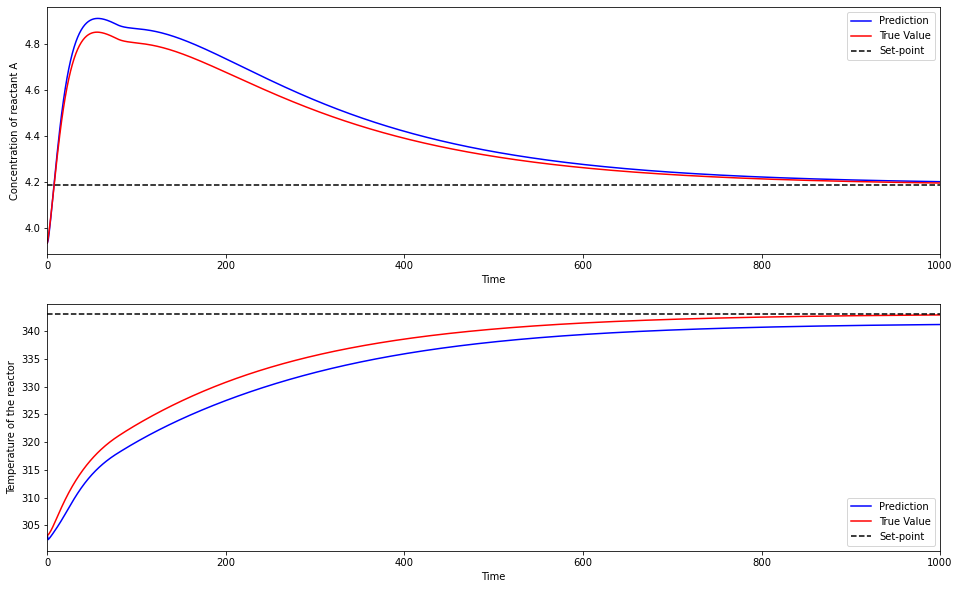

In [10]:
fig = plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.axhline(y=test_set[0,0]+0.25,c='k',label='Set-point',linestyle='--')
plt.xlim((0,1000))
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration of reactant A')

plt.subplot(2, 1, 2)
plt.plot(predictions[:,1],'b',label='Prediction')
plt.plot(true_values[:,1],'r',label='True Value')
plt.axhline(y=test_set[0,1]+40,c='k',label='Set-point',linestyle='--')
plt.xlim((0,1000))
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature of the reactor');